# Proyecto 03 - Sistema de recomendación de videojuegos en Steam

El objetivo del proyecto es crear un sistema de recomendación de videojuegos para la plataforma Steam, esto a partir de las reviews de los usuarios y los datos de los videojuegos.

## 0. Librerias y conformación de los datasets

In [188]:
# Importamos la librerías a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para optimizar el uso de la RAM
import gzip
import gc #garbage collector

# Librerías para la predicción - Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate

In [189]:
# Definimos una función para leer cada linea de los datos comprimidos
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [190]:
# Importar los datos de las caracteristicas de los juegos

# Funcion para coger solo una cantidad de datos en orden
data_games = []
num = 100000
for i, l in enumerate(parse('datos\steam_games.json.gz')):
    data_games.append(l)
    if i == num:
        break

In [191]:
# Importar los datos de las reviews

# Funcion para coger solo una cantidad de datos en orden
data_reviews = []
num = 100000
for i, l in enumerate(parse('datos\steam_reviews.json.gz')):
    data_reviews.append(l)
    if i == num:
        break

In [276]:
# Crear un data frame con los datos
df_games = pd.DataFrame(data_games)
df_rev = pd.DataFrame(data_reviews)

In [259]:
# Revisamos el dataset de reviews
df_rev.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


Notamos que el dataset contiene las siguientes columnas:

* username: Nombre del usuario que realiza la review
* hours: Número de horas que pasó jugando el juego hasta el momento de la review
* products: Cantidad de productos adquiridos por el usuario
* product_id: Código del producto al que le corresponde la review
* page_order: 
* date: Fecha de la reseña
* text: Texto de la reseña
* early_acces: Indica si el usuario recibió acceso temprano al juego o no
* page: página donde se encuentra la reseña
* found_funny: Cantidad de personas que marcaron la reseña como "divertida"
* compensation: Si el juego fue recibido de forma gratuita o no
* user_id: Código de identificación para el usuario

Vamos a limpiar un poco el dataset quitando las columnas que no nos interesan

In [277]:
df_rev = df_rev.drop(columns=['page_order','early_access','page','found_funny','compensation', 'date', 'text'])

También eliminamos aquellas isntancias que se encuentran repetidas en el dataset

In [278]:
# Eliminamos filas duplicadas
df_rev = df_rev.drop_duplicates()

In [279]:
df_rev

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
4,DarklyThinking,16.6,577.0,35140,76561198007483075
...,...,...,...,...,...
99993,apotterx1,1.3,11.0,461560,NaN
99994,Gargoylenbe ✌,0.6,259.0,461560,NaN
99995,edvineriS,0.9,34.0,461560,76561198215396451
99999,MeltDown,1.3,223.0,233270,NaN


Luego, veamos las medidas estadísticas que podemos obtener del dataset

C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='products', ylabel='Density'>

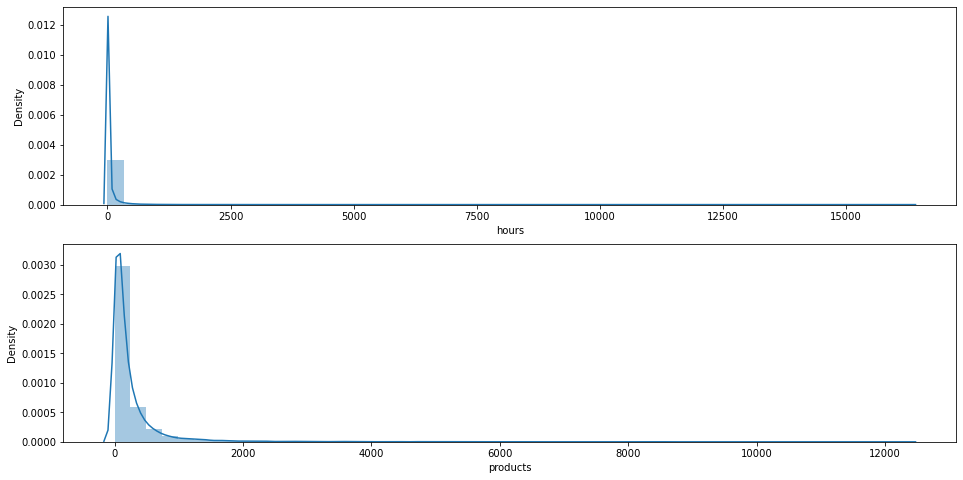

In [280]:
# Obtenemos las distribuciones de las variables a analizar 

fig, axes = plt.subplots(2, 1, figsize=(16,8))

sns.distplot(df_rev['hours'], ax = axes[0])
sns.distplot(df_rev['products'], ax = axes[1])

No es posible apreciar de manera adecuada una distribución de las variables debido a la gran cantidad de datos extremos que tiene en su cola derecha, por lo cual vamos a hacer una limpieza de esta cola con ayuda del rango intercuartílico

In [289]:
# Definimos las columnas sobre las cuales haremos la limpieza
cols_df_rev = ['hours', 'products']

for a in range(len(cols_df_rev)):
    # Determinamos el cuartil 25
    Q1 = df_rev[cols_df_rev[a]].quantile(0.25)
    # Determinamos el cuartil 75
    Q3 = df_rev[cols_df_rev[a]].quantile(0.75)
    # Determinamos el rango intercuartil
    IQR = Q3 - Q1
    # Filtramos los valores
    filter = (df_rev[cols_df_rev[a]] <= Q3 + 3 * IQR)
    df_rev = df_rev.loc[filter]

# Muestra las dimensiones del nuevo dataset
print(df_rev.shape)

(82635, 5)


C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='products', ylabel='Density'>

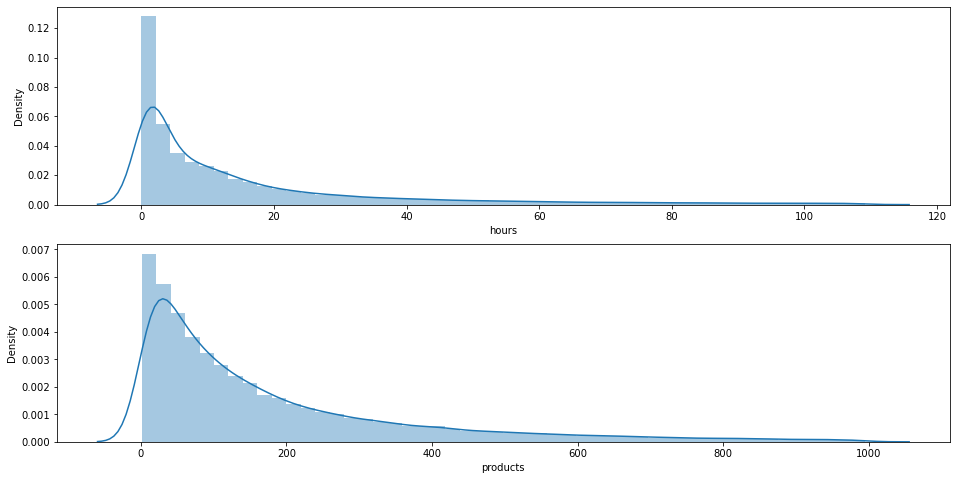

In [265]:
# Obtenemos las distribuciones de las variables a analizar 

fig, axes = plt.subplots(2, 1, figsize=(16,8))

sns.distplot(df_rev['hours'], ax = axes[0])
sns.distplot(df_rev['products'], ax = axes[1])

Aquí podemos observar claramente que tiene la forma de una ley de potencias, donde la mayor cantidad de datos se concentran en menor cantidad de productos y de horas jugadas.

In [266]:
df_rev.describe()

,hours,products
count,82635.000000,82635.000000
mean,15.652988,177.608217
std,21.210575,194.662282
min,0.000000,1.000000
25%,1.800000,41.000000
50%,7.300000,106.000000
75%,19.800000,242.000000
max,109.200000,995.000000


Ahora miraremos los datos faltantes de cada columna

In [267]:
from prettytable import PrettyTable

valNan = PrettyTable()

valNan.field_names = ['Columna','# Valores faltantes']

for a in range(len(cols_df_rev)):
    valNan1 = df_rev[cols_df_rev[a]].isna().sum()
    valNan.add_row([cols_df_rev[a],valNan1])

print(valNan)

+----------+---------------------+
| Columna  | # Valores faltantes |
+----------+---------------------+
|  hours   |          0          |
| products |          0          |
+----------+---------------------+


Para continuar con el análisis, haremos el mismo análisis para el dataset con la información de los juegos para luego relacionarlos

In [268]:
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Las columnas del dataset son:

* <b>publisher:</b> Contiene el nombre del editor 
* <b>genres:</b> Contiene información sobre los géneros que están asociados
* <b>app_name:</b> El nombre 
* <b>title:</b> El título
* <b>url:</b> Dirección web donde se encuentra
* <b>release_date:</b> Fecha de lanzamiento
* <b>tags:</b> Etiquetas colocadas para encontrar el juego
* <b>discount_price:</b> Precio con descuento
* <b>reviews_url:</b> Dirección web de las reseñas
* <b>specs:</b> Especificaciones del juego
* <b>price:</b> Precio full
* <b>early_access:</b> Si el juego tuvo "acceso anticipado" o no
* <b>id:</b> Código de identificación del juego
* <b>developer:</b> Contiene el nombre del desarrollador
* <b>sentiment:</b>
* <b>metascore:</b> 

Antes de eliminar las columnas que no son relevantes del dataset, vamos a ver los datos faltantes y así determinar qué columnas dejar o borrar, debido a que columnas como `"app_names"` y `"title"` parecen contener la misma información, al igual que `"publisher"` y `"developer"`

In [269]:
cols_df_games = list(df_games.columns)
valNan2 = PrettyTable()

valNan2.field_names = ['Columna','# Valores faltantes']

for a in range(len(cols_df_games)):
    valNan3 = df_games[cols_df_games[a]].isna().sum()
    valNan2.add_row([cols_df_games[a],valNan3])

print(valNan2)

+----------------+---------------------+
|    Columna     | # Valores faltantes |
+----------------+---------------------+
|   publisher    |         8052        |
|     genres     |         3283        |
|    app_name    |          2          |
|     title      |         2050        |
|      url       |          0          |
|  release_date  |         2067        |
|      tags      |         163         |
| discount_price |        31910        |
|  reviews_url   |          2          |
|     specs      |         670         |
|     price      |         1377        |
|  early_access  |          0          |
|       id       |          2          |
|   developer    |         3299        |
|   sentiment    |         7182        |
|   metascore    |        29458        |
+----------------+---------------------+


Eliminamos las columnas que no son relevantes para el fin de este proyecto

In [284]:
# Eliminamos las columnas que no son relevantes
df_games = df_games.drop(columns=['publisher', 'title', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs',
                                  'price', 'early_access', 'sentiment', 'metascore', 'genres'])

In [285]:
# Eliminamos las instancias sin valor de 'id' y de 'app_name'

df_games = df_games.dropna(subset=['id', 'app_name'])

KeyError: ['id']

In [286]:
df_games

,app_name,product_id,developer
0,Lost Summoner Kitty,761140,Kotoshiro
1,Ironbound,643980,Secret Level SRL
2,Real Pool 3D - Poolians,670290,Poolians.com
3,弹炸人2222,767400,彼岸领域
4,Log Challenge,773570,NaN
...,...,...,...
32130,Colony On Mars,773640,"Nikita ""Ghost_RUS"""
32131,LOGistICAL: South Africa,733530,Sacada
32132,Russian Roads,610660,Laush Dmitriy Sergeevich
32133,EXIT 2 - Directions,658870,"xropi,stev3ns"


Ahora, vamos a juntar ambos datasets

In [287]:
df_games = df_games.rename(columns={"id": "product_id"})

In [290]:
df_steam = df_rev.merge(df_games, on="product_id")

In [291]:
df_steam

,username,hours,products,product_id,user_id,app_name,developer
0,Chaos Syren,0.1,41.0,725280,NaN,Psi Project,Vyacheslav Shilikhin
1,Teef 🐏,0.9,923.0,725280,NaN,Psi Project,Vyacheslav Shilikhin
2,Sneaky_Panda,0.6,243.0,725280,NaN,Psi Project,Vyacheslav Shilikhin
3,wasp99rock,0.3,48.0,725280,76561198159791799,Psi Project,Vyacheslav Shilikhin
4,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN,Gunspell - Steam Edition,Ino-Co Plus
...,...,...,...,...,...,...,...
82630,AtlasDiesIrae,3.6,150.0,296930,NaN,Ascendant,Hapa Games
82631,Phelyne,4.4,296.0,296930,NaN,Ascendant,Hapa Games
82632,TheChaox,5.5,48.0,296930,76561198121847999,Ascendant,Hapa Games
82633,Crop Duster,54.7,135.0,296930,76561198057527791,Ascendant,Hapa Games


In [292]:
df_steam.isna().sum()

username          0
hours             0
products          0
product_id        0
user_id       49577
app_name          0
developer        64
dtype: int64

# Analisis exploratorio de datos

In [10]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      100001 non-null  object 
 1   hours         99854 non-null   float64
 2   products      99854 non-null   float64
 3   product_id    100001 non-null  object 
 4   page_order    100001 non-null  int64  
 5   date          100001 non-null  object 
 6   text          100001 non-null  object 
 7   early_access  100001 non-null  bool   
 8   page          100001 non-null  int64  
 9   found_funny   17263 non-null   float64
 10  compensation  2523 non-null    object 
 11  user_id       39258 non-null   object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB


## Analisis de datos de info games
- Se ve que las variables de discount_price y las de metascore faltan mucho
- Se observa que esta la feature "sentiment" que nos dice el rating general de el juego
- El nombre del juego es la feature 'title' pero tambien "app name" se puede usar como substituto
- los atributos generos y tags son muy parecidos entre si, solo que genero es solamente tiene los generos de los juegos, pero por esta razon tiene mas naans que tags
- Hay caracteres no occidentales y emojis asi que hay que tener cuidado con los errores de encoding

In [11]:
df_rev.info()
df_rev.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      100001 non-null  object 
 1   hours         99854 non-null   float64
 2   products      99854 non-null   float64
 3   product_id    100001 non-null  object 
 4   page_order    100001 non-null  int64  
 5   date          100001 non-null  object 
 6   text          100001 non-null  object 
 7   early_access  100001 non-null  bool   
 8   page          100001 non-null  int64  
 9   found_funny   17263 non-null   float64
 10  compensation  2523 non-null    object 
 11  user_id       39258 non-null   object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [12]:
len(df_rev[df_rev.duplicated(subset=['username'],keep=False)])

23665

# Analisis de Features datos de review
- hay que usar los datos de username para identificar a los usuarios (creo que los nombres son unicos). Hay que ver de alguna manera si dos personas pueden tener el mismo username.
- El 2.7 porciento del dataset es de personas que hacen varias reviews (Hacer graficos con el numero de reviews que hace una persona)
- La feature "text" puede servir para hacer un analisis de sentimiento
- El numero de horas jugadas puede encodearse para utilizarlo como un suplente de rating

# Graficos
- Coger mas datos a la manera de acamica. 
Para hacer estos graficos necesitamos una dataset mas grande y representativo. Tendremos que usar la funcion que lee una row del dataset cada cierto numero de lines(la funcion que nos da acamica) para evitar solo coger datos de cierto tipo de juegos. Como las reviews estan en un orden, al usar la funcion de datos podriamo accidentalmente, y si las suerte no nos acompaña, escoger un tipo de juego que no represente la totalidad de los juegos, por ejemplog, que en los 1000 datos ordenas cojamos solo los juegod free-to-play, o los juegos indies, que posiblemente tengan reviews mas bajas que otros..


- Hacer un grafico de las horas jugadas del juego #todo
- Hacer un grafico de el numero de reviews que hace la gente #todo

## PARA HACER
- Podemos usar el target como la combinacion de el numero de horas jugadas combinado con el analisis de sentimiento de la review. (primero hacer con el encoding ) #todo

In [29]:
### borrar los nan en horas jugadas
df_rev.hours.isna().sum()
df_rev.dropna(subset=['hours'], inplace=True)

In [42]:
df_rev = df_rev[~(df_rev['hours']==0)]


In [43]:
df_rev.hours.isna().sum()

0

(0.0, 100.0)

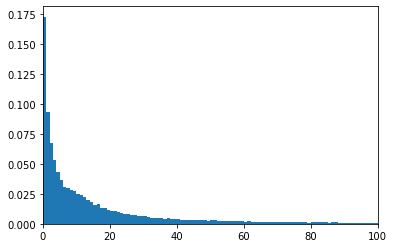

In [44]:
#### encoding de datos
df_rev.hours
plt.hist(x=df_rev.hours, bins=100, density=True, range=(0,100))
plt.xlim([0,100])

(0.0, 50.0)

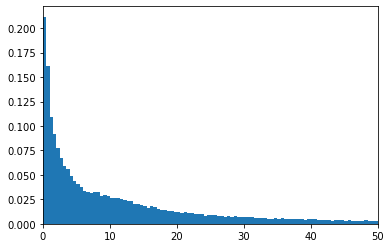

In [45]:
plt.hist(x=df_rev.hours, bins=100, density=True, range=(0,50))
plt.xlim([0,50])

In [46]:
## lo que tenemos aqui es sin duda una power law que vamos a encodear
## de una manera especial.
## normalizar con log
df_rev['log_hours'] = np.log(df_rev.hours)

(-10.0, 10.0)

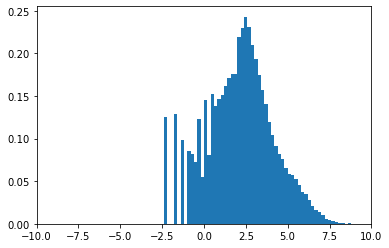

In [47]:
## escalado logaritmico
plt.hist(x=df_rev.log_hours, bins=100, density=True, range=(-10,10))
plt.xlim([-10,10])

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,10))
dataset = scaler.fit_transform(np.asarray(df_rev.log_hours).reshape(-1, 1))

In [49]:
df_rev['escalados'] = dataset

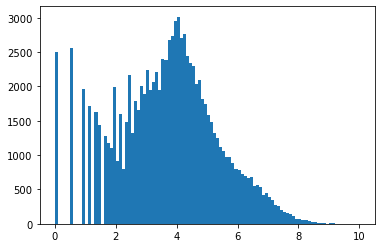

In [50]:
# quedan raros los datos
plt.hist(x=df_rev.escalados, bins=100)
plt.show()

In [51]:
#### meterlos al surprise
# from surprise import Reader, Dataset, SVD, accuracy
# from surprise.model_selection import cross_validate
# columnas user; item; rating; timestamp
# dataset  username; product_id; escalado; date
df_reader = df_rev[['username', 'product_id', 'escalados']] #date lacking
df_reader.dropna(inplace=True)

<ipython-input-51-08d598f4daf4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reader.dropna(inplace=True)


In [107]:
array = df_reader.username.astype(str)

AttributeError: 'DataFrame' object has no attribute 'username'

In [108]:
### encoding the names
from sklearn.preprocessing import OrdinalEncoder

le = OrdinalEncoder()
users = le.fit_transform(np.asarray(array).reshape(-1, 1))
users = users.astype(int)
df_reader.insert(0,'user', users)

ValueError: cannot insert user, already exists

In [ ]:
df_reader = df_reader.drop(columns=['username'])
df_reader

In [109]:
reader = Reader(rating_scale=(1,10), line_format='user item rating')
data = Dataset.load_from_df(df_reader, reader=reader)

In [110]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)

In [111]:
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset
# algo.fit(trainset)
# predictions = algo.test(testset)

# Then compute RMSE
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2466  1.2328  1.2561  1.2500  1.2505  1.2472  0.0078  
MAE (testset)     0.9263  0.9178  0.9353  0.9287  0.9313  0.9279  0.0058  
Fit time          9.66    12.41   10.42   8.14    7.51    9.63    1.74    
Test time         0.24    0.29    0.25    0.16    0.16    0.22    0.05    


{'test_rmse': array([1.24657076, 1.23278544, 1.25611007, 1.24996442, 1.25047488]),
 'test_mae': array([0.92627461, 0.91782745, 0.93526441, 0.92873503, 0.93126451]),
 'fit_time': (9.664250135421753,
  12.409191608428955,
  10.42158842086792,
  8.140044689178467,
  7.507447242736816),
 'test_time': (0.2383861541748047,
  0.28625965118408203,
  0.25209808349609375,
  0.16156625747680664,
  0.16162586212158203)}

In [112]:
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [113]:
predictions[200]

Prediction(uid=63705, iid='465490', r_ui=4.0925047066933855, est=4.206292799060301, details={'was_impossible': False})

In [61]:
algo.predict(9915, 35140)

Prediction(uid=9915, iid=35140, r_ui=None, est=3.6701996758566273, details={'was_impossible': False})

In [75]:
algo.predict(53242, 427730)

Prediction(uid=53242, iid=427730, r_ui=None, est=3.6701996758566273, details={'was_impossible': False})

In [103]:
from collections import defaultdict
from surprise import Dataset

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictionsn(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


196 ['50', '480', '963', '603', '178', '136', '199', '174', '489', '357']
186 ['527', '318', '286', '170', '474', '408', '64', '357', '483', '657']
22 ['169', '98', '408', '166', '178', '357', '315', '64', '23', '198']
244 ['12', '474', '175', '498', '483', '59', '57', '124', '177', '285']
166 ['318', '114', '12', '165', '408', '22', '496', '357', '661', '272']
298 ['408', '313', '64', '169', '12', '272', '114', '528', '923', '316']
115 ['134', '169', '483', '179', '603', '408', '175', '135', '474', '285']
253 ['313', '178', '515', '174', '48', '114', '480', '28', '357', '169']
305 ['114', '603', '132', '1019', '647', '57', '513', '496', '213', '657']
6 ['603', '654', '657', '705', '606', '172', '179', '647', '171', '42']
62 ['169', '480', '150', '223', '408', '272', '23', '603', '657', '427']
286 ['318', '12', '8', '64', '136', '262', '114', '661', '156', '516']
200 ['64', '12', '427', '519', '408', '963', '659', '316', '480', '223']
210 ['318', '169', '408', '511', '480', '272', '479

In [115]:
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

34166 ['452570']
71459 ['245150']
13366 ['291550']
58743 ['350280']
2562 ['350280']
9158 ['271590']
59957 ['291550', '291550', '291550', '224500', '417290', '427730', '390340']
4802 ['427730', '427730']
48194 ['271590']
58329 ['35140']
74053 ['292140', '35140', '13600']
15683 ['291550']
80896 ['280560']
8213 ['32440']
10019 ['291550', '32440', '308040']
40141 ['233270']
14205 ['310370']
10300 ['350280']
12781 ['227940', '291550', '745880', '310370']
543 ['38740']
81854 ['271590']
16427 ['35140']
64755 ['35140']
2307 ['214560']
50498 ['427730']
76870 ['427730']
48789 ['19980']
39126 ['35140', '38740']
39500 ['369080']
51641 ['32440']
72831 ['227940']
20474 ['15210']
79026 ['350280', '8880']
1599 ['271590']
31800 ['310370']
49000 ['427730']
58373 ['274310']
32585 ['35140']
78447 ['357300']
9781 ['11590']
29570 ['385770', '341720']
39950 ['234710']
59592 ['17430', '366700']
40809 ['35140']
35291 ['459820']
44792 ['271590', '35140']
79283 ['310370']
7514 ['385770']
30987 ['308040']
52024 [

73187 ['35140']
83990 ['454320']
55163 ['271590']
9176 ['32440']
23260 ['291550']
27269 ['291550']
77650 ['296300']
22866 ['459820']
39654 ['496980', '300300']
31724 ['291550']
43234 ['326840']
78284 ['17430']
47890 ['459820']
29109 ['310370']
79947 ['35140']
43681 ['224500']
83368 ['385770', '350280']
27517 ['427730', '310370']
22295 ['385770']
61836 ['402170']
4508 ['35140']
79525 ['388210']
14220 ['214560']
69350 ['344340']
3620 ['32440']
11190 ['310360']
83433 ['308040']
47223 ['350280', '388210']
68898 ['35720']
55068 ['224500']
62872 ['17450']
62109 ['214560']
34808 ['330390']
77376 ['326840']
35260 ['227940']
72508 ['35140']
11003 ['224500']
34396 ['214560']
28369 ['230050']
25676 ['459820']
29328 ['35140']
76156 ['388210']
1254 ['427730']
47994 ['354740']
77303 ['259830']
57268 ['291550']
18243 ['233270']
72477 ['359900']
4886 ['13600']
52284 ['35140']
69492 ['337350']
4610 ['230310']
53697 ['310370']
40408 ['214560', '274310']
18952 ['258010']
18151 ['291550']
2136 ['300300', 

6618 ['296300']
61452 ['291550', '291550']
21147 ['26900']
73536 ['388210']
21650 ['214560']
14300 ['280560']
59448 ['214250']
63540 ['454320', '353550']
662 ['461560']
15519 ['308040']
41321 ['274310']
30665 ['214560', '214560']
3994 ['234710']
54418 ['590720']
61349 ['385770']
37132 ['214560']
42550 ['603960']
64010 ['461560']
6100 ['227940']
33724 ['350280']
790 ['330390']
3733 ['233270']
43608 ['385770']
24413 ['8880']
37984 ['245150']
62231 ['384150']
19265 ['200710']
71005 ['341720']
57858 ['291550']
84527 ['32440']
24593 ['335620']
50700 ['274230']
74797 ['214560']
45130 ['35140']
1907 ['271590']
52998 ['337000']
6086 ['274230']
550 ['233270']
58651 ['310370']
27262 ['271590']
65242 ['224500', '415030']
42033 ['427730']
45884 ['292140']
81408 ['449760']
344 ['233270']
73453 ['345260']
33071 ['35140']
40985 ['271590', '274310', '345120']
9089 ['417290']
31949 ['1840']
29230 ['296300', '350280']
42694 ['35140']
6380 ['459820']
70464 ['337000']
6318 ['233270']
7188 ['427730']
20094

11577 ['350280', '274230']
45412 ['350280']
32232 ['350280']
21491 ['390340']
12699 ['291550']
13643 ['11590']
18113 ['214560']
48390 ['452230']
85071 ['357290']
49654 ['291550']
50317 ['291550']
70249 ['271590']
52684 ['369990']
13545 ['271590']
11282 ['274230']
52756 ['32440']
28910 ['427730']
42375 ['271590']
34178 ['8880']
50495 ['234710']
52743 ['234710']
25371 ['271590']
35944 ['291550']
1004 ['386480']
3031 ['214560', '359900', '233270', '350280', '245150', '271860', '660340', '71240']
59351 ['369990']
2387 ['337000']
1033 ['310360']
68620 ['292140']
69226 ['274310']
56161 ['389510']
17592 ['516510']
69375 ['350280']
22004 ['291550']
10290 ['271590']
25357 ['214560']
75482 ['388210']
11055 ['32440']
34298 ['271590']
17900 ['291550', '17450', '330390']
17767 ['291550', '291550']
1113 ['459820']
39127 ['427730']
28673 ['337000', '291550', '234710']
75282 ['339790']
5795 ['61700']
17650 ['35140', '35140', '388210']
39964 ['32440']
30541 ['350280']
54689 ['35140']
47615 ['17430']
19

24861 ['271590']
6808 ['214560', '427730', '310370']
31005 ['350280']
69486 ['337350']
48560 ['268930']
69440 ['308420']
6970 ['8880']
17658 ['296050']
32950 ['350280']
46377 ['233550']
61640 ['291550']
8251 ['1840']
56051 ['214560']
10038 ['350280']
33784 ['61700']
40442 ['350280']
71630 ['465490']
27140 ['35140']
42897 ['47780']
24505 ['245150']
56727 ['224500']
57563 ['200710']
55215 ['310370']
13369 ['417290']
82239 ['291550']
37934 ['384420']
45407 ['389190']
54349 ['35140']
76108 ['35140']
71651 ['35140']
54646 ['310370']
76177 ['32440']
71175 ['415030']
28157 ['271590']
10556 ['17450']
60220 ['274230']
32019 ['271590']
75780 ['337000']
19773 ['310360']
9592 ['274230']
56496 ['275180']
2458 ['350280']
1289 ['427730']
69954 ['275180']
17864 ['200710']
71743 ['310370']
38683 ['384150']
38289 ['337000']
19105 ['415030']
72132 ['339790']
24146 ['274310']
68350 ['274310']
48361 ['271590']
62245 ['291550']
8425 ['241620']
13043 ['17450']
65762 ['389510']
22750 ['386480']
62296 ['385770

35109 ['214560']
25218 ['214560']
51040 ['271590']
53554 ['35140']
46396 ['233270']
12360 ['230050']
7520 ['427730']
29710 ['291550']
54971 ['227940']
80196 ['271590']
51076 ['427730']
14647 ['603960']
64244 ['214560']
71879 ['275180']
68823 ['291550']
50195 ['17450']
36440 ['32440']
53421 ['308420']
42138 ['291550']
81463 ['291550']
81522 ['13600']
21232 ['427730']
31784 ['271590']
15068 ['271590']
79745 ['350280']
61769 ['296300']
29933 ['427730']
28810 ['224500']
71125 ['554220']
5 ['291550']
14141 ['35140']
726 ['214560']
74388 ['291550']
56043 ['35140']
16951 ['71240']
83947 ['291550']
46241 ['19980']
57679 ['214560']
77953 ['291550']
36240 ['35140']
70013 ['230050']
82791 ['459820']
15425 ['209330']
53302 ['227940', '241620']
60396 ['350280']
47557 ['291550', '227940']
52647 ['212500']
42620 ['19980']
68079 ['274310']
58370 ['271590']
60574 ['35140']
16688 ['271590']
66473 ['416380', '271860']
44342 ['35140']
52705 ['35140']
7743 ['389510']
40974 ['459820']
57193 ['310370']
68381

20406 ['300300']
21638 ['350280']
7855 ['497780']
48063 ['350280']
37050 ['341720']
32976 ['214560']
11252 ['274310']
27633 ['200710']
9844 ['271590', '427730']
56359 ['35140']
62148 ['326840']
23248 ['271590']
30606 ['35140']
58674 ['271590']
20343 ['388210']
78150 ['35140']
3297 ['337000']
14746 ['35140', '350280']
19539 ['271590']
38567 ['200710']
70752 ['427730']
58126 ['274230']
64787 ['745880']
11048 ['234710']
17473 ['412940']
17300 ['308040']
14510 ['271590', '337000']
36400 ['337000']
37721 ['385770']
71693 ['15210']
63669 ['459820']
26694 ['271590']
2750 ['291550']
49203 ['310370']
73205 ['427730']
66633 ['385770']
4421 ['271590']
55185 ['233270']
9764 ['38740']
13923 ['35140']
24067 ['214560']
55695 ['230050']
29172 ['274230']
3874 ['330390']
79522 ['291550']
13038 ['214560']
57729 ['296300']
45134 ['262450']
45190 ['274310']
77081 ['271590']
49178 ['386480']
65648 ['308040']
30065 ['415030']
81572 ['603960']
40034 ['291550']
23779 ['427730']
53541 ['7650']
80060 ['530560']


54020 ['310370']
66395 ['275180']
54552 ['35140']
11861 ['200710']
15968 ['233270']
20488 ['224500']
37909 ['274310']
23035 ['291550']
47533 ['61700']
74914 ['385770']
52484 ['35140']
41575 ['389510']
9236 ['441050']
78459 ['61700']
51155 ['385770']
72484 ['461560']
58408 ['292140']
72289 ['350280']
85623 ['388210']
80759 ['388210']
85082 ['459820']
40856 ['224500']
24182 ['17430']
12835 ['286260']
55911 ['280560']
17568 ['357300']
49623 ['350280']
25971 ['35140', '388210']
80580 ['35140']
5109 ['224500']
47668 ['292140']
28180 ['245150']
40361 ['214560']
34104 ['214560']
2350 ['310370']
4715 ['19980']
83043 ['745880']
9432 ['214560']
20873 ['35140']
73061 ['427730']
45810 ['35140']
38164 ['35140', '17430', '38740']
66396 ['271590']
16331 ['291550']
34755 ['441050']
65124 ['214560']
62603 ['385770']
60313 ['357290']
5870 ['291550', '291550']
15229 ['35140']
25574 ['350280']
28144 ['441050']
61950 ['422650']
49269 ['17430']
22303 ['427730']
5847 ['427730']
54926 ['350280']
25653 ['27431

54252 ['399660']
71418 ['35140']
77069 ['292140']
40300 ['363520']
780 ['214560']
12120 ['291550']
9151 ['385770']
35840 ['275180']
62106 ['271590']
82388 ['291550']
57113 ['271590']
81273 ['17430']
29067 ['296300']
32776 ['214560']
21352 ['35140']
5581 ['341770']
55020 ['35140']
50845 ['271590', '427730']
10924 ['345260']
84456 ['271590']
2027 ['388210']
68394 ['427730']
43086 ['61700']
20208 ['35140']
39376 ['427730']
55532 ['458470', '388210']
52676 ['385770']
48172 ['227940', '227940']
53607 ['291550']
74785 ['385770']
54902 ['310360']
7584 ['402980']
298 ['230050']
1822 ['427730']
5878 ['241620']
80447 ['274230']
65704 ['271590']
6567 ['427730']
17352 ['212500']
15680 ['385770']
7187 ['271590', '603960', '699450']
13143 ['385770', '350280']
66130 ['35140']
57834 ['35140']
6851 ['271590']
31732 ['337000']
25340 ['585950']
29262 ['35140']
24080 ['310360']
58093 ['350280']
42505 ['262450']
58094 ['337000']
76817 ['412940']
48299 ['427730']
57944 ['224300']
48794 ['38740']
38228 ['427

26924 ['350280']
81234 ['292140']
28879 ['286260']
29890 ['274230']
13816 ['271590']
2005 ['296300']
3354 ['291550']
35153 ['35140']
82075 ['308040']
15736 ['292140']
43601 ['214560']
54539 ['23450']
18448 ['411080']
70452 ['427730']
29962 ['427730']
27253 ['17430']
51595 ['233550']
65509 ['291550']
18885 ['227940']
42239 ['224300']
7436 ['271590', '427730']
15586 ['745880']
3428 ['285820', '311480']
25288 ['233270']
20558 ['298020']
16321 ['310370']
17008 ['417290', '447000']
7776 ['1840']
2276 ['19980']
61132 ['350280']
32910 ['234710']
32376 ['214560']
4407 ['35140']
5705 ['427730']
52365 ['36300']
71279 ['17430']
18104 ['385770']
56888 ['227940']
56593 ['310370']
17491 ['23450']
37525 ['35140']
73618 ['385770']
32984 ['291550']
27773 ['35140']
67120 ['609410']
18541 ['337000']
49092 ['357290']
48546 ['427730']
8565 ['35140']
50412 ['35140']
14790 ['310360']
49492 ['310370']
47110 ['214250']
3444 ['291550']
77219 ['296300']
38508 ['35140']
9589 ['287020']
55135 ['214560']
7470 ['271

5283 ['274310']
35627 ['214560']
51838 ['345260']
82519 ['274230']
40660 ['427730']
32159 ['291550']
75471 ['389510']
72228 ['214560']
16930 ['385770']
58037 ['350280']
49688 ['427730']
22981 ['350280']
52251 ['258010']
31494 ['350280']
38101 ['271590']
8895 ['296300']
80873 ['224500']
69021 ['224500']
61023 ['61700']
66572 ['35140']
54354 ['271590']
82490 ['427730']
67412 ['263040']
19915 ['35140']
59804 ['459820']
1681 ['350280']
30903 ['224900']
5458 ['227940']
42591 ['427730']
48955 ['271590']
60649 ['487330']
44706 ['233270']
20781 ['291550']
41431 ['296300']
49271 ['35140']
25920 ['224900']
52807 ['227940']
1940 ['61700']
66340 ['350280']
26467 ['200710']
47676 ['35140']
55803 ['274310']
7321 ['19980']
72312 ['400370']
38204 ['35140']
34614 ['427730']
75990 ['271590']
46506 ['35140']
4857 ['296300']
14125 ['530560']
5089 ['280560']
8348 ['214560']
51245 ['310360']
6483 ['296050']
45948 ['233270']
55545 ['357500']
1930 ['291550']
15965 ['61700']
84713 ['310360']
35614 ['261740']
8

47147 ['209330']
4286 ['35140']
61097 ['292140']
45279 ['214560']
14418 ['384150']
4761 ['35140']
30787 ['296300']
49539 ['271590']
60854 ['38740']
82093 ['35140', '274310']
77071 ['35720']
49633 ['17430']
36432 ['350280']
36979 ['214560']
74626 ['35140']
79386 ['271590']
2519 ['427730']
39051 ['427730', '11590']
37125 ['233270']
67088 ['427730']
14065 ['271590']
61178 ['476410']
83258 ['274310']
78707 ['15300']
39227 ['350280']
31836 ['35140']
15090 ['291550']
15448 ['310370']
69065 ['427730']
81002 ['271590']
14493 ['603960']
43634 ['230050']
617 ['291550', '310370']
651 ['296300']
75841 ['258010']
63027 ['271590']
5562 ['399660']
15164 ['271590']
44427 ['310360']
58918 ['291550']
16362 ['224900']
30407 ['291550']
83239 ['337000']
61102 ['35140']
35387 ['385770']
16724 ['245150']
35808 ['214560']
21286 ['13600', '286260']
78377 ['385770']
21341 ['291550', '291550']
21804 ['399660']
9006 ['1840']
40862 ['71240']
68089 ['19980']
8532 ['345260', '356290', '214250']
83549 ['291550', '291

21195 ['38740']
72143 ['310360']
81172 ['35140', '311480']
7294 ['291550']
6423 ['35140']
8668 ['227940']
50267 ['291550']
59878 ['427730']
67826 ['271590']
49854 ['35140']
75127 ['337000']
47433 ['227940']
43246 ['245150']
5486 ['330390']
55491 ['310370']
29813 ['17430']
72958 ['291550']
57828 ['310370']
39155 ['310370']
77463 ['271590']
15772 ['291550']
48084 ['389510']
23852 ['375450']
78239 ['274230']
57795 ['745880']
69761 ['291550']
84319 ['350280']
39881 ['311480']
28241 ['17430']
12025 ['274230']
75850 ['271590']
35721 ['459820']
73461 ['434620']
46589 ['271590']
70218 ['384150']
695 ['13600']
11446 ['230050']
38216 ['330390']
17689 ['35140']
18349 ['427730', '427730']
24312 ['35140']
79732 ['286260']
62088 ['230050']
38666 ['311480']
29372 ['427730', '427730', '519180']
39571 ['350280']
64746 ['271590']
22823 ['274310']
40258 ['427730']
43544 ['291550', '291550']
70339 ['35140']
58230 ['61700']
3547 ['363490']
35741 ['35140']
51157 ['233270']
5277 ['35140']
59746 ['350280']
28

50661 ['296300']
55356 ['427730']
25590 ['390340']
71371 ['330390']
61301 ['35140']
7805 ['330390']
30634 ['35720']
81934 ['384150']
10391 ['35140']
40954 ['32440']
55584 ['427730']
33853 ['385770']
786 ['17430']
83017 ['17430']
70886 ['271590']
7295 ['745880']
38759 ['310370']
13921 ['245150']
40778 ['385770']
59976 ['461560']
172 ['214250']
54706 ['427730']
26882 ['17450']
24537 ['427730']
7699 ['350280']
50979 ['427730']
56093 ['389510']
19844 ['291550']
66047 ['402980']
3017 ['214560']
8205 ['212500']
60762 ['35140']
15854 ['209330']
49439 ['359900']
51826 ['71240']
10472 ['390340']
73046 ['427730']
77617 ['350280', '389510']
25306 ['427730']
10279 ['291550']
82843 ['507380']
67016 ['337000']
31637 ['427730']
1047 ['271590']
61319 ['227940']
71643 ['214560']
25084 ['549740']
74725 ['311480']
38642 ['214560']
66249 ['350280']
24562 ['274310']
41732 ['35140']
63331 ['227940']
28843 ['271590']
74497 ['427730']
9518 ['233270']
34713 ['233550']
41209 ['271590']
64234 ['274310']
49960 ['

29801 ['271590']
33286 ['427730']
14267 ['233550']
43104 ['292140']
10635 ['13600', '19980']
19440 ['35140', '233550']
4336 ['13600']
82939 ['427730']
62458 ['427730']
40531 ['17430']
56049 ['291550']
62595 ['35140']
23713 ['427730']
73114 ['38740']
31008 ['296300', '331450']
5284 ['32900']
76421 ['274230']
22014 ['271590']
8682 ['35140']
31860 ['214560']
74239 ['19980']
65624 ['214560']
57703 ['345260']
37270 ['271590']
13843 ['291550', '292140']
84704 ['308040']
38239 ['38740']
9337 ['35140']
32004 ['258010', '292140']
83103 ['271590']
22183 ['258010', '311480']
15812 ['23450']
35935 ['35140']
78166 ['292140']
74780 ['310370']
69210 ['291550']
68431 ['35140']
29361 ['389510']
62076 ['35140', '210870']
28823 ['71240']
62294 ['262450']
46857 ['35140']
62718 ['350280']
26002 ['441050']
35111 ['427730']
26165 ['603960']
47046 ['415030']
75781 ['47780']
8110 ['271590']
57396 ['224500']
53122 ['35140']
7656 ['428540']
51883 ['350280']
75295 ['38740']
48264 ['310370']
30751 ['389510']
59664

48352 ['291550', '461560']
17348 ['427730']
46900 ['384150']
70279 ['337000']
23301 ['271590']
71611 ['271590']
15332 ['427730']
78204 ['274310']
58529 ['258010']
38972 ['427730']
65317 ['35140']
74277 ['296300']
42913 ['1840']
3795 ['286260']
47141 ['337000']
4102 ['19980']
36101 ['300400']
67891 ['15210']
56610 ['310370']
81670 ['350280']
3376 ['357290']
65137 ['233270']
40852 ['224500']
83501 ['271590']
30498 ['35140']
76715 ['388210']
18409 ['274230']
77278 ['245150']
52386 ['291550']
64374 ['350280']
61230 ['291550']
70802 ['35140']
39860 ['357290']
67822 ['350280']
74161 ['308420']
46749 ['292140']
56096 ['427730']
72632 ['271590']
43886 ['291550']
43919 ['427730']
66424 ['35140']
80209 ['200710']
37079 ['292140']
39217 ['341720']
85318 ['271590']
44696 ['274310']
65481 ['35140']
76436 ['291550']
13745 ['214560']
16914 ['271590']
81581 ['35140']
1073 ['32440']
45546 ['374090']
32565 ['459820', '214560', '233270']
73545 ['241620']
17684 ['214560']
57340 ['271590']
46976 ['224500']

56221 ['745880']
63964 ['271590', '47780']
21005 ['296300']
9558 ['275180', '363520', '224900']
24750 ['459820']
83084 ['459820']
53975 ['214560']
12910 ['233270']
25913 ['35140']
74107 ['369990']
82829 ['363490']
7791 ['339790']
49882 ['385770']
40989 ['427730']
60970 ['415030']
43465 ['291550']
73617 ['427730']
26454 ['233550']
38586 ['390340']
9038 ['234710']
39245 ['245150']
76542 ['271590']
63157 ['389510']
29224 ['286260']
76308 ['291550']
45907 ['214560']
5758 ['296300']
4461 ['209330']
2453 ['291550']
35046 ['369990']
57058 ['291550']
47989 ['452570']
76638 ['19980']
35910 ['525700']
83959 ['384210']
49587 ['330390']
43418 ['32440']
484 ['271590']
20673 ['291550']
10392 ['385770']
36460 ['38740']
71203 ['660340']
42749 ['385770']
79067 ['227940']
36626 ['310360']
13840 ['271590']
85103 ['310360']
47945 ['233270']
9993 ['350280']
63742 ['344340']
46424 ['32440']
59190 ['310360']
16840 ['214560']
42515 ['19980']
62432 ['214560']
74766 ['17430']
41941 ['230050']
13157 ['291550']
7

81093 ['11590']
7695 ['271590']
55633 ['427730']
79926 ['23450']
28483 ['271590', '337000']
1703 ['274310', '274230']
67830 ['385770']
85186 ['13600']
22318 ['214560', '214560']
79742 ['459820', '459820']
33743 ['241620']
73003 ['427730']
61163 ['292140']
65783 ['35140']
24563 ['271590']
41806 ['35140']
46729 ['35140']
51510 ['271590']
15125 ['427730', '427730']
64901 ['465490']
4906 ['350280']
54806 ['292140']
27307 ['310370']
35538 ['492340']
22878 ['427730']
82134 ['310360']
35298 ['23450']
42433 ['291550']
77880 ['350280']
2173 ['200710']
34430 ['291550']
18344 ['341720']
79139 ['326840']
84385 ['271590']
73430 ['411080']
70493 ['38740']
84520 ['271590']
43783 ['287020']
80134 ['286260']
77941 ['224500']
41123 ['385770']
60308 ['35140', '13600']
35090 ['291550']
65226 ['292140']
62323 ['23450']
49045 ['35720']
54583 ['385770']
18013 ['230050']
84519 ['271590']
54614 ['214560']
35278 ['415030']
62385 ['17430']
56754 ['506510']
35542 ['35140']
81141 ['274230']
48017 ['32440']
68203 [

2382 ['251210']
56694 ['227940']
48261 ['385770']
23824 ['369990']
77684 ['263040']
19467 ['200710']
17129 ['214560']
17323 ['428540']
73213 ['292140']
66384 ['35140']
45739 ['214560']
67652 ['15210']
80742 ['291550']
4864 ['233550']
7413 ['357300']
84994 ['271590']
8484 ['335620']
81801 ['227940']
33609 ['26900']
18293 ['330390']
67563 ['292140']
17536 ['402980']
83615 ['385770']
29704 ['516510']
33380 ['337000']
47397 ['258010']
7507 ['280560']
50170 ['291550']
48291 ['274310']
22427 ['385770']
31664 ['291550']
45619 ['292140']
14455 ['292140']
75846 ['326840']
64623 ['316700']
70238 ['286260']
30079 ['427730']
37012 ['15210']
24241 ['47780']
7100 ['214560']
44694 ['233270']
42599 ['525700']
79269 ['698640']
74237 ['461560']
61676 ['271590']
76276 ['363490']
7319 ['262450']
670 ['310360']
80022 ['271590']
38041 ['274310']
21439 ['212500']
9792 ['461560']
33191 ['427730']
15044 ['427730']
45352 ['291550']
14548 ['291550']
85167 ['271590']
59266 ['265240']
75027 ['291550']
27345 ['3514

60519 ['390340']
52622 ['337000']
2736 ['388210']
30272 ['61700']
72272 ['530560']
27878 ['291550']
16646 ['308420']
37146 ['271590']
57913 ['350280']
22842 ['200710']
20693 ['310370']
12205 ['17450']
50505 ['459820']
79650 ['459820']
14054 ['310370']
48469 ['233270']
43340 ['292140']
4344 ['271590']
5866 ['274310']
68733 ['291550']
46157 ['388210']
26259 ['427730']
84132 ['291550']
20111 ['271590']
5289 ['35140']
49257 ['745880']
37188 ['274310']
45440 ['291550']
7812 ['291550']
69158 ['427730']
8006 ['287020']
12582 ['17450']
246 ['15210']
29888 ['390340']
80249 ['258010']
49454 ['227940']
42911 ['308420']
38219 ['350280']
56587 ['310360']
65129 ['214560']
81862 ['363490']
79207 ['61700']
85141 ['745880']
18181 ['35140']
84648 ['427730']
37118 ['313040']
41151 ['291550']
20176 ['271860']
26144 ['8880', '357290']
22270 ['459820']
37588 ['17450']
40748 ['271590']
54284 ['35140']
22824 ['230050']
39274 ['603960']
29065 ['308040']
56642 ['32440']
23978 ['35140', '390340']
84766 ['350280'

24065 ['427730']
76059 ['350280']
6645 ['350280']
13222 ['350280']
2930 ['427730']
58315 ['492340']
6345 ['296300']
8043 ['350280']
37159 ['1610']
67693 ['214250']
6785 ['427730']
78612 ['200710']
44591 ['384150']
14468 ['212500']
58291 ['525700']
1087 ['357290']
13153 ['725550']
10655 ['32440']
77079 ['291550', '291550']
18343 ['19980']
13123 ['310360']
41945 ['263800']
58786 ['271590']
85581 ['291550']
13106 ['427730']
50655 ['230050']
17123 ['271590', '38740']
20540 ['324060']
5364 ['337000']
83153 ['350280']
31206 ['19980']
64114 ['350280']
35501 ['13600']
85072 ['227940']
45304 ['337000']
81996 ['310370']
33210 ['61700']
58295 ['310370']
42784 ['214560']
54521 ['384150']
63688 ['296300']
22398 ['274310']
11291 ['32440']
84732 ['385770']
41965 ['291550']
82383 ['35140']
56511 ['271590']
43988 ['292140', '310370']
37049 ['38740']
82364 ['296300']
10508 ['271590']
54327 ['341720']
12537 ['345120']
59679 ['337000']
82175 ['35140']
25660 ['271590']
538 ['271590']
62161 ['427730']
11447

73616 ['388210']
43824 ['227940']
84219 ['271590']
22695 ['38740']
63101 ['300300']
38853 ['23450']
2434 ['35140', '7650', '38740']
31425 ['296300']
31895 ['11590']
20378 ['271590']
57794 ['745880']
3662 ['357500']
12553 ['391000']
17672 ['214560']
63271 ['427730']
23878 ['388210']
24632 ['389510']
24653 ['19980']
49100 ['227940']
28515 ['271590']
58700 ['245150']
26171 ['350280']
64788 ['233270']
29893 ['275180']
64991 ['291550']
77358 ['291550']
16785 ['35140']
72383 ['385770']
62697 ['230050']
69374 ['275180']
74133 ['227940']
66806 ['259830']
77171 ['385770']
63082 ['336100']
78995 ['245150']
43595 ['291550']
11084 ['234710']
48871 ['291550']
11229 ['35140', '389190']
4115 ['271590']
31475 ['590720']
47213 ['427730']
41408 ['61700', '427730']
9195 ['47780']
28295 ['227940']
67734 ['516510']
82213 ['337000']
49585 ['291550']
59079 ['427730']
80003 ['274230']
12046 ['427730']
22025 ['459820']
59596 ['337000']
79710 ['8880']
6860 ['385770']
34787 ['427730']
54890 ['291550']
85352 ['27

69289 ['310370']
7034 ['350280']
6722 ['347440']
40081 ['271590']
54 ['427730']
85140 ['271590']
84265 ['271590']
28940 ['35140']
75042 ['427730']
18553 ['337350']
71566 ['35140']
26376 ['427730']
52393 ['32440']
688 ['292140']
17513 ['263040']
27910 ['385770']
44886 ['286260']
46365 ['35140']
60680 ['427730']
23693 ['310360']
83610 ['310370']
65107 ['350280']
36991 ['291550']
57654 ['388420']
63506 ['258010']
4878 ['262450']
16075 ['427730']
42269 ['32440']
73565 ['384150']
11213 ['525700']
64315 ['344340']
21821 ['350280']
77231 ['35140']
76656 ['291550']
74253 ['42850']
68003 ['316700']
17844 ['427730']
83951 ['745880']
29642 ['427730']
1549 ['200710']
2709 ['384150']
45935 ['35140']
41425 ['412940']
57123 ['350280']
8531 ['32440']
44358 ['214250']
45552 ['271590']
13328 ['350280']
1758 ['292140']
74933 ['209330']
49991 ['291550']
43775 ['214560']
6707 ['427730']
4369 ['210870']
53905 ['548760']
46441 ['699450']
29895 ['487330']
33958 ['227940']
32479 ['61700']
22052 ['310370']
7251

4554 ['369990']
3134 ['224500']
75928 ['271860']
36174 ['292140']
72206 ['200710']
24762 ['310370']
32414 ['32440']
28606 ['350280']
2053 ['324060']
83165 ['233270']
72085 ['35140']
32983 ['17430']
61888 ['35140']
7293 ['335620']
10906 ['562760']
40515 ['271590']
40759 ['296300']
3776 ['35140']
11038 ['310370']
11081 ['271590']
70564 ['427730']
14735 ['271590']
25855 ['274310']
5191 ['345120']
53532 ['271590']
20597 ['385770']
8101 ['227940']
13237 ['214560']
34860 ['291550']
59874 ['274230']
25151 ['291550']
608 ['459820']
73553 ['214560']
4093 ['388210']
20200 ['214560']
78680 ['487330']
76758 ['310360']
52245 ['230050']
45013 ['459820']
67359 ['427730']
61334 ['35140']
80951 ['291550']
6989 ['291550']
82088 ['214560']
11504 ['262450']
9672 ['11590']
72313 ['35140']
49018 ['35140']
28841 ['35140']
8081 ['525700']
17523 ['227940']
49031 ['271590']
49998 ['224500']
43117 ['385770']
46169 ['35140']
54505 ['271590']
24004 ['310370']
63384 ['285820']
11528 ['452570']
63857 ['345260']
5301

66778 ['286260']
38484 ['230050']
14587 ['285820']
74761 ['291550']
1798 ['274310']
20593 ['427730']
36344 ['17450']
69179 ['274310']
60547 ['459820']
1820 ['13600']
53325 ['427730']
11514 ['35140']
66419 ['224500']
62636 ['233270']
80328 ['427730']
12412 ['516510']
21699 ['271590']
32465 ['296300']
24057 ['286260']
47745 ['292140']
53783 ['214560']
12099 ['38740']
72947 ['326840']
5260 ['385770', '38740']
49656 ['35140']
72154 ['35140']
435 ['38740']
4214 ['214560']
57770 ['245150']
59471 ['427730']
22566 ['26900']
20579 ['1840']
21654 ['26900']
35432 ['337000']
52926 ['427730']
47930 ['271590']
47218 ['245150']
26556 ['35140']
4518 ['271590']
56413 ['310370']
42011 ['385770']
51121 ['308040']
22929 ['35140']
15943 ['354740']
71219 ['385770']
27198 ['230050']
52388 ['275180']
6641 ['271590']
29977 ['214560']
37568 ['224500']
33641 ['200710']
52953 ['35140']
4014 ['271590']
68856 ['330390']
32873 ['399660']
36119 ['224500', '224500']
69034 ['427730']
63717 ['35140']
73518 ['291550']
34

11175 ['274230']
39899 ['339790']
50386 ['35140']
25893 ['375450']
85344 ['459820']
23365 ['271590']
84984 ['271590', '427730']
26282 ['35140']
85539 ['291550']
6691 ['32440']
16007 ['385770']
28425 ['336520']
8582 ['341720']
67842 ['38740']
64442 ['427730']
1773 ['350280']
64818 ['427730']
54104 ['251210']
80861 ['205990']
73405 ['385770']
43107 ['291550']
66417 ['15210']
33893 ['274310']
11448 ['274310']
18351 ['214560']
30539 ['35140']
50211 ['214560']
23290 ['291550']
79108 ['427730']
20999 ['230050']
80912 ['337000']
24598 ['350280']
14463 ['427730']
34893 ['285820']
48995 ['271590']
9751 ['292140']
55755 ['35140']
82455 ['71240']
7524 ['310370']
83293 ['271590']
16956 ['32440']
43129 ['296300']
19485 ['209330']
43497 ['459820']
53059 ['310370']
15954 ['230050']
76286 ['298020']
27715 ['35140']
48841 ['17450']
1044 ['427730']
1908 ['280560']
74660 ['308040']
79701 ['35140']
532 ['291550', '291550']
62590 ['388210']
24142 ['291550']
62175 ['390340']
81471 ['214560']
70431 ['227940'

3384 ['233550']
72832 ['285820']
36995 ['17450']
14567 ['212500']
84278 ['271590']
2859 ['427730']
15346 ['280560']
9226 ['427730']
84105 ['271590']
13714 ['296300']
2372 ['291550']
21011 ['230050']
76449 ['212500']
73100 ['35140']
15580 ['214560']
10704 ['350280']
15550 ['227940']
65258 ['385770']
53042 ['224500']
57564 ['350280']
81532 ['233270']
37803 ['35140']
37126 ['427730']
63598 ['233550']
44530 ['427730']
17153 ['427730']
81521 ['427730']
76418 ['35140']
6986 ['308420']
85277 ['233270']
64151 ['335620']
13602 ['35140', '32440']
15383 ['389510']
20405 ['296050']
1041 ['271590']
61941 ['32440', '32440']
75941 ['341720']
26162 ['11590']
14732 ['336520']
39510 ['35140']
52202 ['233550']
50366 ['357290']
37246 ['17450']
30125 ['271590']
31122 ['15210']
16376 ['230050']
3198 ['17430']
42527 ['427730']
36067 ['32440']
56425 ['214560']
16113 ['745880']
85153 ['350280']
34383 ['214560']
77578 ['227940']
35764 ['427730']
19229 ['271590']
48740 ['35140']
79489 ['385770']
32747 ['427730']

84942 ['291550']
53262 ['108210']
16571 ['350280']
75058 ['291550']
11795 ['291550']
37435 ['427730']
14380 ['271590']
8591 ['427730']
36982 ['200710']
6737 ['388210']
53796 ['35140']
68025 ['291550']
9611 ['212500']
31037 ['388210']
2777 ['214560']
40889 ['291550']
83864 ['233270']
70909 ['350280']
52634 ['350280']
68482 ['214560']
13534 ['271590']
68472 ['271590']
23741 ['32440']
31376 ['214250']
77021 ['385770']
77259 ['291550']
49557 ['350280']
24519 ['291550']
167 ['291550']
43294 ['603960']
42748 ['35140']
22410 ['388210']
61962 ['8790']
48309 ['233270']
60066 ['1840']
17497 ['271590']
77846 ['310370']
31109 ['227940']
65458 ['17430']
28098 ['35140']
76362 ['310370']
26251 ['35140', '233550']
44504 ['292140']
73396 ['427730']
23614 ['465490']
63568 ['389510']
68304 ['452570']
3316 ['339790']
69078 ['427730']
50803 ['369990']
83065 ['35140']
6386 ['13600']
6806 ['271590']
25465 ['17450']
28484 ['26900']
54561 ['287020']
68880 ['291550']
31020 ['32440']
35955 ['224300']
76383 ['245

31019 ['427730']
81886 ['291550']
27694 ['214560']
11196 ['530560']
23901 ['427730']
46142 ['35140']
80431 ['296050']
31985 ['350280']
83890 ['271590']
55368 ['427730']
55978 ['200710']
4159 ['326590']
38654 ['434620']
76336 ['35140']
23587 ['61700']
2395 ['350280']
57569 ['224900']
13572 ['311480']
46705 ['17450']
10483 ['209330']
25308 ['233270']
8689 ['516510']
7605 ['214560']
45608 ['38740']
63152 ['35140']
25269 ['241620']
55877 ['35140']
14149 ['353550']
14801 ['233270']
47444 ['745880']
74642 ['300400']
22319 ['271590']
67121 ['291550']
11226 ['296300']
62974 ['291550']
55995 ['214560']
76230 ['337000']
347 ['745880']
9306 ['337000']
59903 ['390340']
50512 ['369990']
40667 ['427730']
9637 ['452570']
32872 ['310360']
1756 ['310370']
72691 ['271590']
79784 ['359900']
34289 ['233270']
10020 ['274230']
54570 ['35140']
27518 ['271590']
67414 ['271590']
11015 ['271590']
31615 ['291550']
7603 ['350280']
71427 ['310370']
38623 ['35140']
68017 ['336520']
81325 ['388210']
79487 ['291550']

1863 ['271590']
26876 ['233270']
35335 ['233270']
80988 ['400370']
71214 ['35140']
15193 ['234710']
1962 ['745880']
43268 ['291550']
9898 ['35140']
50965 ['200710']
14170 ['61700']
68000 ['35140']
50303 ['35140']
71769 ['427730']
16019 ['230050']
2965 ['337000']
48891 ['26900']
43692 ['271590']
8750 ['32440']
55856 ['345120']
61461 ['274310']
59214 ['357300']
21688 ['35140']
12152 ['680990']
30217 ['308420']
28285 ['390340']
51032 ['214560']
27958 ['291550']
22535 ['427730', '427730']
23117 ['35140']
14709 ['427730']
23705 ['292140']
9697 ['271590']
12818 ['234710']
55924 ['337000']
12850 ['441050']
52573 ['271590']
4396 ['258010']
69476 ['427730']
10231 ['271590']
67171 ['385770']
2706 ['38740']
2905 ['411080']
4730 ['233270']
10534 ['23450']
59601 ['341720']
82887 ['227940']
44324 ['745880']
71518 ['230050']
73171 ['427730']
76753 ['280560']
40767 ['35140']
31057 ['61700']
57971 ['330390']
84467 ['1840']
84515 ['745880']
74009 ['291550']
28997 ['200710']
44578 ['363520']
24966 ['3244

37426 ['292140']
84993 ['337000']
4284 ['452420']
74652 ['13600']
11356 ['292140']
21451 ['214560']
34750 ['280560']
27266 ['427730']
49750 ['245150']
72416 ['38740']
13680 ['13600']
73982 ['32440']
69009 ['326840']
18362 ['310370']
2637 ['214560']
6792 ['227940']
85418 ['745880']
81715 ['427730']
46693 ['336520']
38949 ['214250']
1793 ['291550']
38979 ['286260']
30872 ['274230']
11101 ['15210']
8862 ['15210']
504 ['233270']
3272 ['8880']
24317 ['1610']
25741 ['300300']
21918 ['525700']
357 ['427730']
62100 ['296300']
5456 ['35140']
39395 ['350280']
43472 ['296300']
30701 ['375290']
2080 ['385770']
10872 ['345260']
81492 ['291550']
20047 ['224500']
47550 ['274230']
14625 ['310360']
82056 ['337000']
51551 ['209330']
59383 ['427730']
39637 ['310360']
63581 ['354740']
64256 ['13600']
75310 ['35140']
45233 ['292140']
85204 ['363490']
66937 ['61700']
82667 ['271590']
42201 ['388420']
24277 ['369990']
15242 ['274310']
36393 ['369990']
57052 ['350280']
72364 ['35140']
2117 ['316700']
43212 ['

25729 ['359900']
74943 ['363490']
11454 ['296050']
23798 ['427730']
13729 ['330390', '341720']
62539 ['308420']
33133 ['271590']
53891 ['291550']
393 ['32440']
2873 ['292140']
25577 ['350280']
6639 ['388210']
51336 ['32440']
57048 ['427730']
21177 ['209330']
84669 ['390340']
11157 ['375450']
75782 ['227940']
23325 ['337000']
26890 ['224500']
64301 ['350280']
1835 ['271590']
37872 ['224500']
78468 ['271590']
25038 ['385770']
38080 ['359900']
45195 ['422650']
50575 ['427730']
47185 ['61700']
56893 ['427730']
68808 ['258010']
38970 ['227940']
49231 ['271590']
7821 ['427730']
45587 ['745880']
50645 ['385770']
25842 ['291550']
71450 ['32440']
81849 ['214560']
29505 ['224900']
44172 ['274230']
20549 ['412940']
67802 ['245150']
75918 ['13600']
62564 ['339790']
72919 ['17450', '310360']
999 ['32440']
27628 ['274310']
23082 ['214560']
10653 ['292140']
51163 ['603960']
45106 ['227940']
15946 ['233270']
72080 ['214560']
77888 ['274230']
41726 ['350280']
58361 ['271590']
76002 ['389510']
72091 ['3

50001 ['35140']
7849 ['296300']
56572 ['427730']
9948 ['350280']
65273 ['428540']
51181 ['385770']
6812 ['291550']
21554 ['271590']
36254 ['17430']
8456 ['363520']
80956 ['350280']
71609 ['227940']
51950 ['461560']
73938 ['291550']
11869 ['200710']
60392 ['465490']
54643 ['271590']
78361 ['427730']
8838 ['427730']
43648 ['350280']
74534 ['7650']
36648 ['35140']
84666 ['291550']
23265 ['38740']
38992 ['350280']
49580 ['35140']
18525 ['214560']
9299 ['745880']
69725 ['389510']
37244 ['1840']
23249 ['271860']
47567 ['35140']
65928 ['271590']
30148 ['291550']
65452 ['390340']
46112 ['271590']
42650 ['310370']
7400 ['291550']
53402 ['698640']
7018 ['296300']
49488 ['357290']
43435 ['35140']
52407 ['274230']
31673 ['291550']
23783 ['427730']
80085 ['427730']
33693 ['8790']
39043 ['214560']
21219 ['35140']
9203 ['214560']
38799 ['292140']
5529 ['310370']
17597 ['275180']
48239 ['227940']
61889 ['233270']
85430 ['337000']
78588 ['427730']
80942 ['310370']
39878 ['35140']
21478 ['427730']
78552

In [99]:
len(get_top_n(predictions, n=10))


23679

In [127]:
predictions[1]

Prediction(uid=71459, iid='245150', r_ui=3.551040703178769, est=2.835345049306072, details={'was_impossible': False})

- Mirar si hay correlación entre categorías de juegos recomendados según las predicciones encontradas
- Agregar datos al dataset 